# CS 584 :: Data Mining :: George Mason University :: Spring 2024


# Homework 5: Recommender Systems

- **100 points [8% of your final grade]**
- **Due Sunday, April 28 by 11:59pm**

- *Goals of this homework:* implement the Matrix Factorization algorithm.

- *Submission instructions:* for this homework, you only need to submit to Blackboard. Please name your submission **FirstName_Lastname_hw5.ipynb**, so for example, my submission would be something like **Ziwei_Zhu_hw5.ipynb**. Your notebook should be fully executed so that we can see all outputs. 

# Part 1. Matrix Factorization (70 points total)

For this part, we will:

* load and process the MovieLens 1M dataset, 
* build a matrix factorization model,
* evaluate the model.

To start out, we need to prepare the data. We will use the MovieLens 1M data from https://grouplens.org/datasets/movielens/1m/ in this homework. Lucky for you, we are providing the file containing the ratings -- ratings.dat  -- so all you need to do is loading the ratings.dat file in the notebook as a DataFrame variable using the Pandas library. The code to do this has been provided in the next cell, but you need to run it. The DataFrame variable is named as 'data_df'. The code names the column of movie id as 'MovieID', names the column of user id as 'UserID', names the column of rating as 'Rating', and the column of timestamp as 'Timestamp'. After this, the first 5 rows of data_df are printed out by DataFrame.head().

Note that you should install the pandas library before you use it. For more information about Pandas, here is a quick introduction: https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html. 

In [3]:
import pandas as pd
import numpy as np

data_df = pd.read_csv('./ratings.dat', sep='::', 
                      names=["UserID", "MovieID", "Rating", "Timestamp"], 
                      engine='python')
data_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Now let's find some simple statistics for this dataset. In the next cell, please count and print how many unique users, unique movies, and how many ratings there are in this dataset. 

**Hint: You may need to use the function pandas.Series.unique(), as introduced in https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html.**

In [4]:
# count and print how many unique users, unique movies, and ratings in this dataset
# Your Code Here...
unique_user = set()
unique_movie = set()
rating = []

for i in range(len(data_df)):
    unique_user.add(data_df.iloc[i,0])
    unique_movie.add(data_df.iloc[i,1])
    rating.append(data_df.iloc[i,2])

print(len(unique_user))
print(len(unique_movie))
print(len(rating))

6040
3706
1000209


Because in Python, the index for a list starts from 0, it is more convenient if we have the ids of users and movies start from 0 as well. Moreover, we also need to make sure the UserID and MovieID are continuous, so in the next cell, we reindex UserID and MovieID. The code is already provided, but you still need to run it. (It may take a few minutes to run it.)

In [5]:
# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
for j in range(len(data_df)):
    data_df.at[j, 'UserID'] = user_old2new_id_dict[data_df.at[j, 'UserID']]
    data_df.at[j, 'MovieID'] = movie_old2new_id_dict[data_df.at[j, 'MovieID']]

data_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


Now, you have got a ready-to-use dataset. The next step is to split it **randomly** into training and testing sets so that you can build your recommendation model based on the training set and evaluate it on the testing set. Here you need to split the data_df into two parts: a DataFrame **train_df** containing 70% user-movie-rating samples in data_df, and a DataFrame **test_df** containing 30% samples. train_df and test_df should have no overlap. In the next cell, write your code and print the numbers of samples in the generated train_df and test_df at last.

**Note that here we just have training and testing sets without using a validation set for the sake of simplicity. This is not a good paradigm in practice.**

**Hint: you may need to use functions from numpy.random for generating random numbers.**

In [6]:
# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
# Your Code Here...
train_df = data_df.sample(frac = 0.7)
test_df = data_df.drop(train_df.index)
# End of your code

print('num of train_df = ' + str(len(train_df)))
print('num of test_df = ' + str(len(test_df)))

num of train_df = 700146
num of test_df = 300063


Last, we need to generate numpy array variables (i.e., matrix version of dataset) for both train_df and test_df for the ease of calculation in the next step. More specifically, we will generate two numpy array variables of size (#user by #movie) with each entry representing the user-movie rating. And if the user-movie rating is missing, then the corresponding entry is 0. The code is already provided, but you still need to run it and it is a good chance for you to check the correctness of your previous code by running the provided code. 

**Hint: Please make sure you have already installed the scipy library before running the code.**

In [7]:
from scipy.sparse import coo_matrix

num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)), 
                       shape=(num_user, num_movie)).toarray().astype(float)
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)), 
                      shape=(num_user, num_movie)).toarray().astype(float)

With the processed data, let's implement the matrix factorization (MF for short) model introduced in class. The MF model can be mathematically represented as: 

<center>$\underset{\mathbf{P},\mathbf{Q}}{\text{min}}\,\,L=\sum_{(u,i)\in\mathcal{O}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2+\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$,</center>
    
where $\mathbf{P}$ is the user latent factor matrix of size (#user, #latent); $\mathbf{Q}$ is the movie latent factor matrix of size (#movie, #latent); $\mathcal{O}$ is a user-movie pair set containing all user-movie pairs having ratings in train_mat; $r_{u,i}$ represents the rating for user u and movie i; $\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$ is the regularization term to overcome overfitting problem, $\lambda$ is the regularization weight (a hyper-parameter manually set by developer, i.e., you), and $\lVert\mathbf{P}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{P}_{x,y})^2$, $\lVert\mathbf{Q}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{Q}_{x,y})^2$. Such an L function is called the **loss function** for the matrix factorization model. The goal of training an MF model is to find appropriate $\mathbf{P}$ and $\mathbf{Q}$ to minimize the loss L.

To implement such an MF, here we will write a Python class for the model. There are three functions in this MF class: init, train, and predict. 

* The 'init' function (**already provided**) is to initialize the variables the MF class needs, which takes 5 inputs: train_mat, test_mat, latent, lr, and reg. 'train_mat' and 'test_mat' are the corresponfing training and testing matrices we have. 'latent' represents the latent dimension we set for the MF model. 'lr' represents the learning rate, i.e., the update step in each optimization iteration, default is 0.01. 'reg' represents the regularization weight, i.e., the $\lambda$ in the MF formulation.

* The 'train' function (**partially provided and need to complete**) is to train the MF model given the training data train_mat. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main body of this function should be a loop for 'epoch' iterations. In each iteration, following the algorithm to update the MF model:

        1. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs having ratings in train_mat)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}^\prime_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}^\prime_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight.</center>
        
        3. After iterating over all user-movie pairs, we have finished the training for the current epoch. Now calculate and print out the value of the loss function L after this epoch, and the RMSE on test_mat by the current MF model. Then append them to lists to keep a record of them.
The train function needs to return two lists: 'epoch_loss_list' recording the loss after each training epoch, and 'epoch_test_RMSE_list' recording the RMSE on test_mat after each training epoch. The calculation of RMSE is formulated as:
<center>$RMSE=\sqrt{\frac{1}{|\mathcal{O}_{test}|}\sum_{(u,i)\in\mathcal{O}_{test}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2}$</center> 
<center>where $\mathcal{O}_{test}$ is a user-movie pair set containing all user-movie pairs having ratings in test_mat, and $|\mathcal{O}_{test}|$ represents the total number of user-movie pairs in test_mat.</center>

* The 'predict' function (**already provided**) is to calculate the prediction_mat by the learned $\mathbf{P}$ and $\mathbf{Q}$.


In the next cell, we provide the 'init' and 'predict' functions. You will need to fill in the 'train' function based on the description above. 

**NOTE: Make sure that $\mathbf{P}^\prime_u$ and $\mathbf{Q}^\prime_i$ are both calculated by original $\mathbf{P}_u$ and $\mathbf{Q}_i$ from the previous iteration.**

**NOTE: use matrix calculation instead of an iterative method to calculate test RMSE: use code similar to**
- test_rmse = (np.sum(((prediction_mat - self.test_mat) * self.test_indicator_mat) ** 2) / np.sum(self.test_indicator_mat)) ** 0.5

**NOTE: you should not delete or modify any provided code, you only need to add your code between "start of your code" and "end of your code" comments.**

In [15]:
class MF:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie pairs having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.train_indicator_mat = 1.0 * (train_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in train_mat
        self.test_indicator_mat = 1.0 * (test_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in test_mat

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized

    def train(self, epoch=20, verbose=True):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch 
        Output: epoch_loss_list -- a list recording the training loss for each epoch
                epoch_test_RMSE_list -- a list recording the testing RMSE after each training epoch
        """
        epoch_loss_list = []
        epoch_test_RMSE_list = []
        for ep in range(epoch):
            """ 
            Write your code here to implement the training process for one epoch, 
            and at the end of each epoch, print out the epoch number, the training loss after this epoch, 
            and the test RMSE after this epoch
            """
            # start of your code
            permutation = np.random.permutation(self.num_sample)
            shuffled_user_indices = self.sample_user[permutation]
            shuffled_movie_indices = self.sample_movie[permutation]

            # Gradient descent for each user-movie pair
            for idx in range(self.num_sample):
                u = shuffled_user_indices[idx]
                i = shuffled_movie_indices[idx]
                rating = self.train_mat[u, i]
                pred = self.P[u, :].dot(self.Q[i, :])
                err = pred - rating

                # Calculate the gradients
                grad_P = 2*err * self.Q[i, :] + 2*self.reg * self.P[u, :]
                grad_Q = 2*err * self.P[u, :] + 2*self.reg * self.Q[i, :]

                # Update the factors
                self.P[u, :] -= self.lr * grad_P
                self.Q[i, :] -= self.lr * grad_Q

            # Compute the loss for the epoch
            prediction_matrix = self.predict()
            error_matrix = (self.train_mat - prediction_matrix) * self.train_indicator_mat
            epoch_loss = np.sum(error_matrix**2) + self.reg * (np.sum(self.P**2) + np.sum(self.Q**2))

            # Compute RMSE for the test set
            error_matrix_test = (self.test_mat - prediction_matrix) * self.test_indicator_mat
            test_rmse = np.sqrt(np.sum(error_matrix_test**2) / np.sum(self.test_indicator_mat))
            # End of your code for this function
            
            epoch_loss_list.append(epoch_loss)
            epoch_test_RMSE_list.append(test_rmse)
#             if verbose:
#                 print('Epoch={0}, Training Loss={1}, Testing RMSE={2}'.format(ep + 1, epoch_loss, test_rmse))
            
        return epoch_loss_list, epoch_test_RMSE_list
        
        
    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T)
        return prediction_mat

Now, let's train an MF model based on your implementation. The code is provided, you just need to excute the next cell. The expectations are: 

* first, the code can be successfully excuted without error; 
* second, the training loss and RMSE on **test_mat** of each training epoch should be printed out for all 20 epochs;
* last, the best RMSE on **test_mat** should be <0.92.


**Hint: the expected time used for training is around 10s to 60s per training epoch.**

In [12]:
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

Epoch=1, Training Loss=612649.2858756845, Testing RMSE=0.951362620698961
Epoch=2, Training Loss=600712.2652604281, Testing RMSE=0.9460585282207126
Epoch=3, Training Loss=590224.0106503309, Testing RMSE=0.9423610698596026
Epoch=4, Training Loss=573009.3973524849, Testing RMSE=0.9345237498965222
Epoch=5, Training Loss=553160.2725910738, Testing RMSE=0.9232655885299742
Epoch=6, Training Loss=538316.1818888139, Testing RMSE=0.9152927692725685
Epoch=7, Training Loss=527911.2933966558, Testing RMSE=0.9107211083589838
Epoch=8, Training Loss=520325.6969385142, Testing RMSE=0.9066608647233647
Epoch=9, Training Loss=514439.4389117474, Testing RMSE=0.9051607783466781
Epoch=10, Training Loss=509602.96621492517, Testing RMSE=0.9024526794307356
Epoch=11, Training Loss=507696.75112856505, Testing RMSE=0.9021355795460306
Epoch=12, Training Loss=503685.57341255934, Testing RMSE=0.9013882893962175
Epoch=13, Training Loss=501176.7217337042, Testing RMSE=0.898982769182869
Epoch=14, Training Loss=499427.79

# Part 2: Tune Hyper-parameters in Matrix Factorization (30 points)

In Part 1, we train an MF model with latent dimension set as 5, regularization weight as 0.001, training epoch as 20. However, it is not clear whether these are good choices or not. Hence, in this part, we will tune these hyper-parameters to train an effective model.

A most straightforward but powerful method is to grid search each hyper-parameter and find the best one based on the RMSE on test_mat. In this part, we will do the grid search for train epoch, latent dimension, and regularization weight.

### Tune training epoch

For training epoch, we only need to run the experiment of MF for one time, and record the test RMSE for each epoch and find the epoch that produces the best test RMSE. To visually show the change of test RMSE corresponding to the training epoch, we can plot the test RMSE for each epoch in a figure as shown in the next cell.

**Note that you need to first install the matplotlib, then you can excute the next cell**

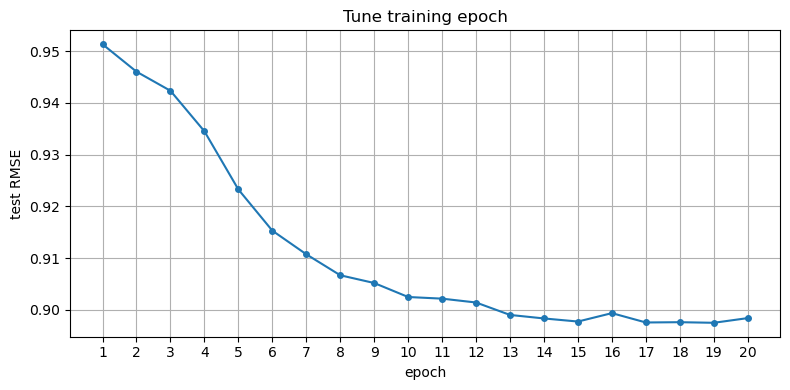

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(np.arange(len(epoch_test_RMSE_list)) + 1, epoch_test_RMSE_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(epoch_test_RMSE_list)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('epoch')
ax.set_title('Tune training epoch')
ax.grid(True)
plt.tight_layout()
plt.show()

### Question: Based on this plot, what is the best epoch for your MF model?

#### Write your answer here
The Best epoch of the model is on epoch 19.

### Tune latent dimension

By this figure, you can find the best epoch for your MF model. Similarly, you can plot how the test RMSE changes when you set different latent dimensions. For this, you need to run the code to initialize and train the MF model for multiple times with different settings of 'latent'. Please run the MF model with 'latent' as {1,3,5,7,9}, and plot the corresponding test RMSE for these five different latent dimensions in the next cell. 

**Note that for these five runs of experiments, record the test RMSE after Ep training epochs -- Ep is the best epoch you find by the 'Tune training epoch' plot. And here, fix regularization weight as 0.001**.

**Note that the expected output of the next cell is just the plot, you don't need to show the code and printing of the experiment with different 'latent' here.**

Latent dimension running: 1
Latent dimension running: 3
Latent dimension running: 5
Latent dimension running: 7
Latent dimension running: 9


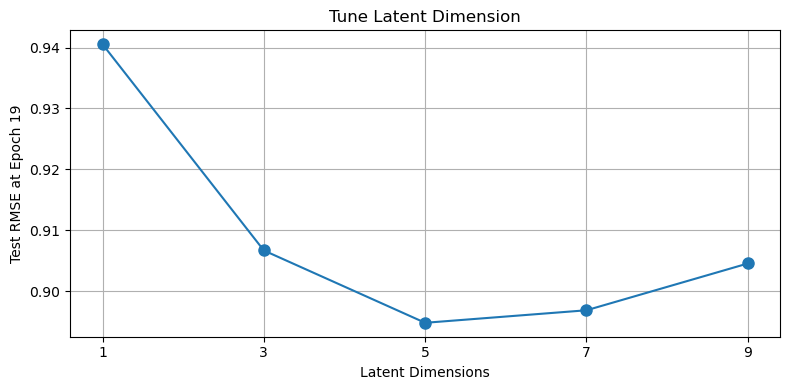

In [18]:
import matplotlib.pyplot as plt

best_epoch = 19
latent_dims = [1, 3, 5, 7, 9]
rmse_at_best_epoch = []

for latent in latent_dims:
    print("Latent dimension running:", latent)
    mf = MF(train_mat, test_mat, latent=latent, lr=0.01, reg=0.001)
    _, epoch_test_RMSE_list = mf.train(epoch=best_epoch)
    rmse_at_best_epoch.append(epoch_test_RMSE_list[-1])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(latent_dims, rmse_at_best_epoch, marker='o', linestyle='-', linewidth=1.5, markersize=8)

ax.set_xticks(latent_dims)
ax.set_xlabel('Latent Dimensions')
ax.set_ylabel('Test RMSE at Epoch 19')
ax.set_title('Tune Latent Dimension')
ax.grid(True)
plt.tight_layout()
plt.show()

### Question: Based on this plot, what is the best latent dimension for your MF model?

#### Write your answer here
Latent = 5

### Tune regularization weight

Last, you can plot how the test RMSE changes when you set different regularization weight. Please run the MF model with 'reg' as {0.0001,0.0005,0.001,0.0015,0.002}, and plot corresponding test RMSE for these five different regularization weights in the next cell. 

**Note that for these five runs of experiments, record the test RMSE after Ep training epochs -- Ep is the best epoch you find by the 'Tune training epoch' plot. And here, fix latent dimension as the one you find the best by the previous part**

**Note that the expected output of the next cell is just the plot, you don't need to show the code and printing of the experiment with different 'reg' here.**

Training with regularization weight: 0.0001
Training with regularization weight: 0.0005
Training with regularization weight: 0.001
Training with regularization weight: 0.0015
Training with regularization weight: 0.002


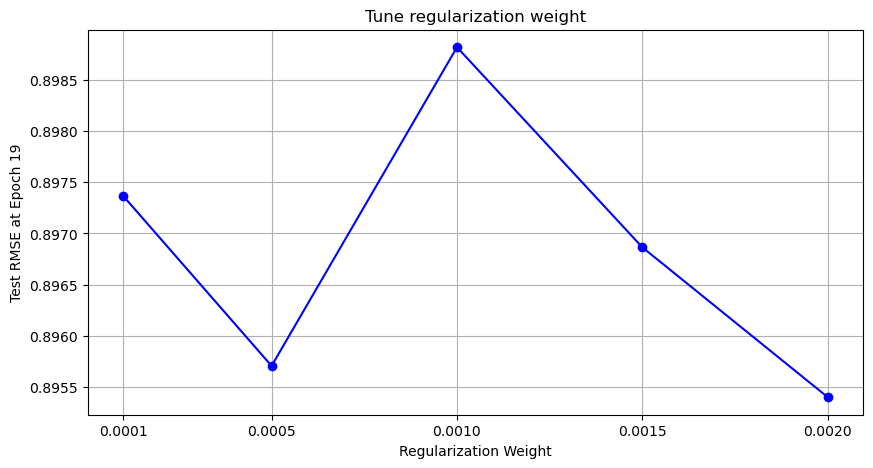

In [19]:
import matplotlib.pyplot as plt
import numpy as np

regularization_weights = [0.0001, 0.0005, 0.001, 0.0015, 0.002]
rmse_at_epoch_19 = []

for reg in regularization_weights:
    print(f"Training with regularization weight: {reg}")
    mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=reg)
    _, epoch_test_RMSE_list = mf.train(epoch=19)  
    rmse_at_epoch_19.append(epoch_test_RMSE_list[-1])

plt.figure(figsize=(10, 5))
plt.plot(regularization_weights, rmse_at_epoch_19, marker='o', linestyle='-', color='blue')
plt.title('Tune regularization weight')
plt.xlabel('Regularization Weight')
plt.ylabel('Test RMSE at Epoch 19')
plt.xticks(regularization_weights)
plt.grid(True)
plt.show()

### Question: Based on this plot, what is the best regularization weight for your MF model?

#### Write your answer here
regularization = 0.002